In [33]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import os
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda
from VGGish.vggish import VGGish
import VGGish.vggish_params as params
from VGGish.vggish_input import wavfile_to_examples
from DataGenerator import ClassificationDataGenerator, FingerprintingDataGenerator
from ModelLogger import ModelLogger
np.random.seed(42)
tf.version.VERSION

Using TensorFlow backend.


'2.1.0'

In [3]:
vgg_ish = VGGish(include_top=False,pooling='avg', n_non_trainable_conv=5)
vgg_ish.summary()

Model: "VGGish"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 64, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 400, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 200, 32, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 200, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 100, 16, 128)      0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 100, 16, 256)      295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 100, 16, 256)      59008

# Experiment 1 - Binary Classification

In [46]:
positive_class = 'Chorus'
base_model = 'VGGish'
version = 'v0.1'
model_name = '_'.join(['binary',base_model,positive_class, version])
last_layer = vgg_ish.get_layer(index=-1).output
x = Dense(1024, activation='relu',name='dense1')(last_layer)
x = Dropout(0.3, name='dropout1')(x)
x = Dense(32, activation='relu', name='dense2')(x)
x = Dropout(0.3, name='dropout2')(x)
x = Dense(1, activation='sigmoid',name='output')(x)
binary_model = Model(inputs=vgg_ish.get_layer(index=0).input,outputs=x, name=model_name)
binary_model.summary()

Model: "binary_VGGish_Chorus_v0.1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 64, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 400, 64, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 200, 32, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 200, 32, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 100, 16, 128)      0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 100, 16, 256)      295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 100, 

In [47]:
binary_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
pre_trained_model = './TrainedModels/chorus_model_v0.1.h5'
binary_model = tf.keras.models.load_model(pre_trained_model)

In [48]:
data_dir_train = './Spectrograms/train'
data_dir_val = './Spectrograms/val'
batch_size = 64
binary_generator_train = ClassificationDataGenerator(
    data_dir=data_dir_train,
    batch_size=batch_size,
    mode='binary',
    positive_class=positive_class,
#     exclude_class='Chorus'
)
binary_generator_val = ClassificationDataGenerator(
    data_dir=data_dir_val,
    batch_size=batch_size,
    mode='binary',
    positive_class=positive_class,
#     exclude_class='Chorus'
)
chart_callback = ModelLogger('accuracy')

<Figure size 432x288 with 0 Axes>

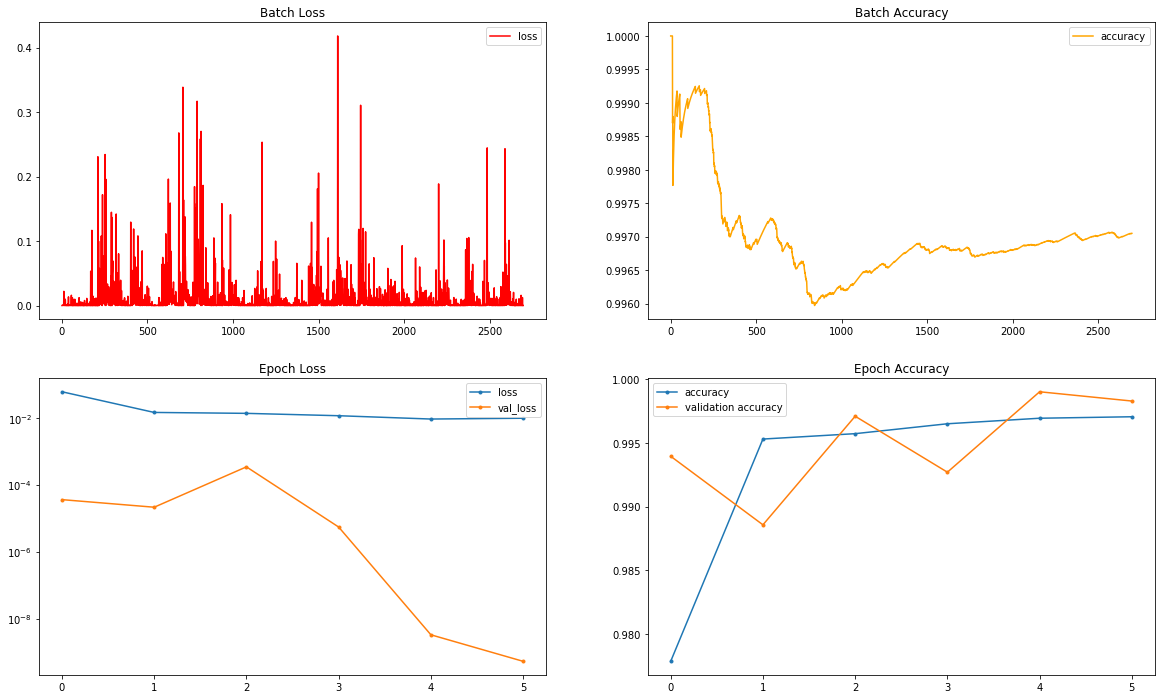

Epoch 7/200
 181/2697 [=>............................] - ETA: 9:34:04 - loss: 0.0060 - accuracy: 0.9981

KeyboardInterrupt: 

In [49]:
binary_model.fit(
    binary_generator_train,
    validation_data=binary_generator_val,
    epochs=200,
    callbacks=[chart_callback]
) 

In [50]:
models_folder = 'TrainedModels'
model_path = os.path.join('.',models_folder,binary_model.name+'.h5')
binary_model.save(model_path)

# Experiment 2 - Fingerprinting

In [2]:
def get_encoder():
    from keras.models import Model, Sequential
    from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
    import VGGish.vggish_params as params
    
    input_shape = (params.NUM_FRAMES, params.NUM_BANDS, 1)
    aud_input = Input(shape=input_shape, name='input_1')
    # Block 1
    x = Conv2D(8, (3, 3), strides=(1, 1), activation='relu', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(16, (3, 3), strides=(1, 1), activation='relu', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)
    
    # Block 3
    x = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', name='conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)
    
    x = Flatten(name='flatten1')(x)
    model = Model(aud_input, x, name='encoder')
    return model

In [15]:
def get_siamese(feature_extractor = 'VGGish',ENCODED_DIM=128,n_non_trainable_conv = None):
    """
    Returns a siamese network with encoder specified
    Params
    ----------
        feature_exctractor - possible values are 'VGGIsh' or 'custom'
        ENCODED_DIM - length of embedding vector
    """
    pooling = 'avg'
    if feature_extractor == 'VGGish':
        model = VGGish(include_top=False,pooling=pooling,n_non_trainable_conv=n_non_trainable_conv)
    elif feature_extractor == 'custom':
        model = get_encoder()
    else:
        raise ValueError("Feature Extractor must be either 'VGGish' or 'custom'")
    
    version = 'v0.1'
    model_name = '_'.join(['fingerprinting',feature_extractor,str(ENCODED_DIM), version, pooling, str(n_non_trainable_conv)])
    input_shape = (params.NUM_FRAMES, params.NUM_BANDS, 1)
    left_input = Input(input_shape, name='Left_Input')
    right_input = Input(input_shape, name='Right_Input')
    last_layer = model.get_layer(index=-1).output
    x = Dense(ENCODED_DIM, activation='relu',name='encoded')(last_layer)
    encoder = Model(inputs = model.layers[0].input, outputs=x, name='Encoder')
    encoded_l = encoder(left_input)
    encoded_r = encoder(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]), name="L1_Layer")
    L1_distance = L1_layer([encoded_l, encoded_r])
    out = Dense(1,activation='sigmoid',name='output')(L1_distance)
    siamese_net = Model(inputs = [left_input,right_input],outputs=out, name=model_name)
    return siamese_net

In [20]:
siamese_net = get_siamese(feature_extractor='VGGish',ENCODED_DIM=128,n_non_trainable_conv=6)
siamese_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
siamese_net.summary()

Model: "fingerprinting_VGGish_128_v0.1_avg_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Left_Input (InputLayer)         (None, 400, 64, 1)   0                                            
__________________________________________________________________________________________________
Right_Input (InputLayer)        (None, 400, 64, 1)   0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 128)          4565376     Left_Input[0][0]                 
                                                                 Right_Input[0][0]                
__________________________________________________________________________________________________
L1_Layer (Lambda)               (None, 128)          0         

In [21]:
fingerprint_gen_train = FingerprintingDataGenerator(
    data_dir = './Spectrograms/train',
    sampling_mode='balanced',
    num_of_steps_per_epoch = 100,
    batch_size = 32,
    exclude_class='Chorus'
)
fingerprint_gen_val = FingerprintingDataGenerator(
    data_dir = './Spectrograms/val',
    sampling_mode='all',
    batch_size = 128,
    exclude_class='Chorus'
)
charting_callback = ModelLogger('accuracy')

<Figure size 432x288 with 0 Axes>

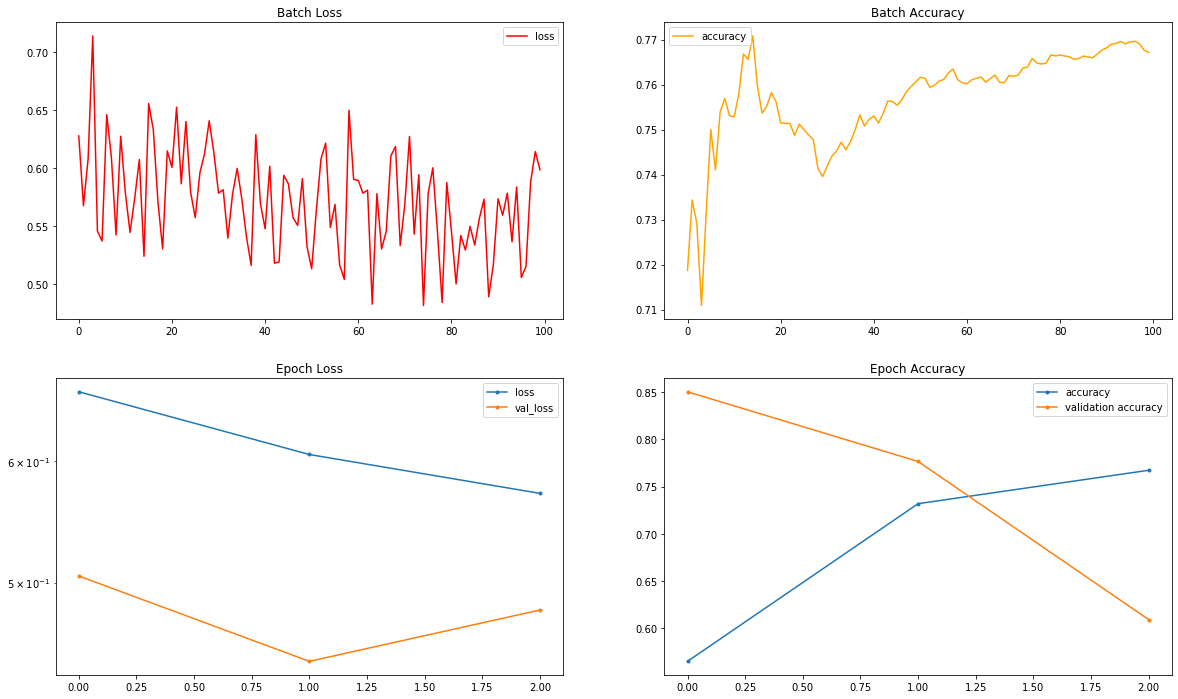

Epoch 4/500
 99/100 [============================>.] - ETA: 4s - loss: 0.5453 - accuracy: 0.7762

KeyboardInterrupt: 

In [22]:
siamese_net.fit(
    fingerprint_gen_train,
    validation_data = fingerprint_gen_val,
    epochs=500,
    callbacks=[charting_callback]
)

In [7]:
# siamese_net.name = ''
models_folder = 'TrainedModels'
model_path = os.path.join('.',models_folder,siamese_net.name + '.h5')
siamese_net.save(model_path)

In [29]:
m = siamese_net.get_layer(name="Encoder")
m.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 64, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 398, 62, 8)        80        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 199, 31, 8)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 197, 29, 16)       1168      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 98, 14, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 96, 12, 32)        4640      
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 48, 6, 32)         0   